**Week 7: Markov Chain Monte Carlo of multi-particle simulations with
Metropolis importance sampling**

Jannek Schaffert, Frédéric Sonak

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

**Background**

In this exercise, we implement a Monte Carlo (MC) simulation using the Metropolis algorithm to model particles interacting in a box with periodic boundary conditions. The interactions are governed by the Lennard-Jones potential, which accounts for attractive and repulsive forces between particles.

Unlike previous exercises focused on molecular dynamics (MD), this exercise emphasizes stochastic sampling with MC, where particle moves are accepted or rejected based on energy changes. The goal is to observe the system’s behavior, analyze potential energy convergence, and compare MC results to MD simulations.



In [1]:
# Importing all utilised libraries

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualisation
import time

from numba import njit

import copy
import numpy as np
import scipy as scy

In [2]:
# Monte Carlo Simulation
def monte_carlo_simulation(particles, steps, step_shift, temperature, C12, C6, box_size, record_interval):
    '''Monte-Carlo Simulation using Metropolis Algorithm with a Lennard-Jones Potential.'''


# Helper function to calculate the potential energy
    def calculate_potential_energy(particles, C12, C6, iu, box_size):

        #first calculate distances
        # Calculate distances in x-direction

        # first calculate matrix upper triangle distances
        d_raw = (particles[1, :, np.newaxis] - particles[np.newaxis, 1])[iu]

        # take into account periodic boundaries
        dx = np.where(np.abs(d_raw) > box_size * 0.5, d_raw - box_size * np.sign(d_raw), d_raw)


        # Calculate distances in y-direction
        d_raw = (particles[2, :, np.newaxis] - particles[np.newaxis, 2])[iu]
        dy = np.where(np.abs(d_raw) > box_size * 0.5, d_raw - box_size * np.sign(d_raw), d_raw)

        # Total distances
        # r = np.sqrt(dx**2 + dy**2)
        # r6 = r**6
        # for faster calculation don't calculate the square root but use r squared

        r = dx**2 + dy**2
        r6 = r**3

        # Return potential energy
        return np.sum(C12 / r6**2 - C6 / r6)


    start_time = time.time()  # Start timing the simulation

    N = particles.shape[1]
    R = 8.314462  # Gas constant
    c = 1 / (R * temperature)

    # initialise Arrays for storing trajectory and energy

    # Trajectory storage at defined intervals
    traj = np.ones((steps // record_interval, 2, N))
    # Potential energy storage
    energ_pot = np.ones(steps)

    # to access the upper triangle of the matrix
    # 1 excludes diagonal elements
    iu = np.triu_indices(N, 1)

    E_old = calculate_potential_energy(particles, C12, C6, iu, box_size)
    energ_pot[0] = E_old
    traj[0] = particles[[1, 2]]

    for step in tqdm(range(1, steps), desc="Monte Carlo Progress"):
        for i in range(N):
            # Save old positions
            pos_old = particles[1:3, i].copy()

            # Apply random displacement
            angles = np.random.uniform(0, 2 * np.pi)
            displacement = np.array([np.cos(angles), np.sin(angles)]) * step_shift
            particles[1:3, i] = (particles[1:3, i] + displacement) % box_size

            # Calculate new energy
            E_new = calculate_potential_energy(particles, C12, C6, iu, box_size)

            # Metropolis acceptance
            if (E_new < E_old) or (np.random.rand() < np.exp((E_old - E_new) * c)):
                E_old = E_new  # Accept move
            else:
                particles[1:3, i] = pos_old  # Revert move

        if step % record_interval == 0:
            traj[step // record_interval] = particles[[1, 2]]
        energ_pot[step] = E_old

    end_time = time.time()  # End timing the simulation
    runtime = end_time - start_time  # Calculate runtime
    print(f"MC Simulation completed in {runtime:.2f} seconds.")

    return energ_pot / N, traj



**Task 2: Simulation**

In this task, a 2D simulation box of size  $5 \, \text{nm} \times 5 \, \text{nm}$  is created with periodic boundary conditions (PBC). The simulation models $49$ particles interacting via the Lennard-Jones potential, with the following parameters:
	•	 $C_{12} = 9.847044 \times 10^{-6} \, \text{kJ/mol} \, \text{nm}^{12}$
	•	 $C_{6} = 6.2647225 \times 10^{-3} \, \text{kJ/mol} \, \text{nm}^6$

The system is initialized at $293.15 K$, and $100,000$ single-particle moves are performed following the Monte Carlo (MC) algorithm. During the simulation, the potential energy of the system is calculated and used to evaluate the acceptance of particle moves.

Warning: MC simulations can be computationally intensive, especially with a large number of steps. If the simulation takes too long, reduce the number of steps (e.g., 2,000 steps) to test the setup before running the full simulation.



In [3]:
# Parameters for the simulation
box_size = 5.0  # Box size in nm
N_particles = 49  # Number of particles

C12 = 9.847044e-3  # Lennard-Jones constant for repulsion kg, nm, ns
C6 = 6.2647225  # Lennard-Jones constant for attraction kg, nm, ns
temperature = 293.15  # Temperature in K
step_shift = 0.01  # Random displacement step size in nm
steps = 100000  # Total Monte Carlo steps
record_interval = 20  # Save trajectory every 20 steps

# manually placing particles on a evenly spaced grid
# Initialize particle positions (regular grid)
particles = np.zeros((5, N_particles))  # Mass, x, y, vx, vy

# Create a regular grid within the box
grid_size = int(np.sqrt(N_particles))  # Number of particles per row/column
spacing = box_size / grid_size  # Spacing between particles

# Assign positions
x_coords = np.linspace(spacing / 2, box_size - spacing / 2, grid_size)
y_coords = np.linspace(spacing / 2, box_size - spacing / 2, grid_size)
x, y = np.meshgrid(x_coords, y_coords)

# create a 1D array
particles[1] = x.flatten()[:N_particles]  # x-coordinates
particles[2] = y.flatten()[:N_particles]  # y-coordinates





In [4]:
# Run the Monte Carlo simulation with the above parameters
energ_pot_mc, traj_mc = monte_carlo_simulation(particles, steps, step_shift, temperature, C12, C6, box_size, record_interval)

Monte Carlo Progress: 100%|██████████| 99999/99999 [07:20<00:00, 226.92it/s]

MC Simulation completed in 440.70 seconds.


**Task 3: Potential energy analysis**

We analysed the system’s potential energy during the Monte Carlo simulation:

1. Potential Energy Over Steps:

The potential energy of the system was plotted as a function of simulation steps. This allowed us to observe how the energy evolves and whether the system approaches equilibrium.

2. Histogram of Equilibrated Potential Energies:

We assumed that the system reaches equilibrium during the second half of the simulation, where fluctuations in potential energy become stable. Using this data, a histogram of potential energies was calculated to visualize the distribution of energies in the equilibrated state.

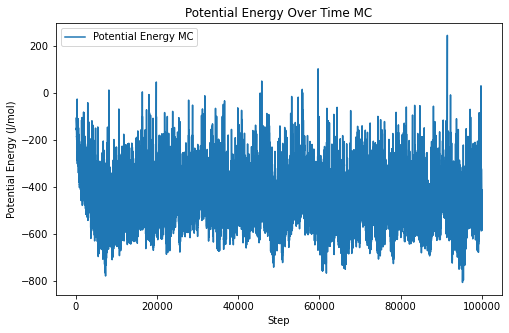

In [5]:
# Plot the system’s potential energy over the number of steps
plt.figure(figsize=(8, 5))
plt.plot(range(steps), energ_pot_mc, label="Potential Energy MC")
plt.xlabel("Step")
plt.ylabel("Potential Energy (J/mol)")
plt.title("Potential Energy Over Time MC")
plt.legend()
plt.show()


The equilibrated part of the simulation is identified as the phase where the fluctuations in potential energy become "stable" (i.e. a converging constant mean), resulting in an almost horizontal trend in the potential energy plot. We assume that equilibrium is reached in the second half of the simulation. Therefore, the histogram of potential energies is calculated using data from the second half of the simulation steps.

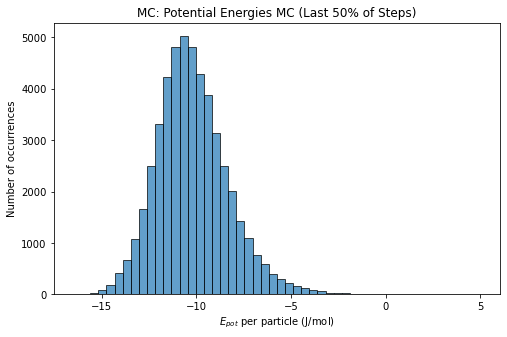

In [6]:

# Select the last 50% of the steps
last_half_start_mc = len(energ_pot_mc) // 2
last_half_energies_mc = energ_pot_mc[last_half_start_mc:]

# Normalize potential energy per particle for the last half
last_half_energies_per_particle_mc = last_half_energies_mc / particles.shape[1]
# Divide by number of particles

# Plot histogram
plt.figure(figsize=(8, 5))
plt.title("MC: Potential Energies MC (Last 50% of Steps)")
plt.hist(last_half_energies_per_particle_mc, bins=50, edgecolor='k', alpha=0.7, label="Histogram")
plt.xlabel("$E_{pot}$ per particle (J/mol)")
plt.ylabel("Number of occurrences")
plt.show()


Does it look like a Boltzmann distribution? I would say yes :-)


**Task IV: RDF and free energy comparison with MD**

To compare the MC simulation with the MD simulation the MD simulation has to be rerun from previous excercises.



In [16]:

# Function to calculate forces and potential energy
def calculate_forces(particles, box_size, c12, c6):
    """
    Vectorized calculation of Lennard-Jones forces and potential energy.
    Parameters:
        particles: Array with particle positions (shape: (2, N)).
        box_size: Size of the simulation box (scalar).
        c12, c6: Lennard-Jones constants.
    Returns:
        forces: Array of forces acting on particles (shape: (2, N)).
        potential_energy: Total potential energy of the system.
    """
    # Compute pairwise distances with periodic boundary conditions
    delta = particles[:, np.newaxis, :] - particles[:, :, np.newaxis]  # Shape: (2, N, N)
    delta -= box_size * np.round(delta / box_size)  # Apply periodic boundary conditions
    # Squared distances (don't use sqrt for compuational reasons) (N, N)
    r2 = np.sum(delta**2, axis=0)

    # Mask out self-interaction
    np.fill_diagonal(r2, np.inf)

    # Lennard-Jones potential
    r6 = r2**3
    r12 = r6**2
    potential_energy_matrix = c12 / r12 - c6 / r6

    # Total potential energy
    potential_energy = np.sum(potential_energy_matrix) * 0.5

    # Lennard-Jones force magnitudes (gradient of potential)
    force_magnitude = (12 * c12 / r12 - 6 * c6 / r6) / r2

    # Calculate forces
    forces = np.sum(force_magnitude * delta, axis=1)  # Shape: (2, N)

    return forces, potential_energy

# MD Simulation Function (Velocity-Verlet Algorithm)
def run_md_simulation(particles, box_size, c12, c6, time_step, n_steps, mass):
    """
    Perform a Molecular Dynamics simulation using the Velocity-Verlet algorithm.

    """

    start_time = time.time()

    N = particles.shape[1]  # Number of particles
    positions = particles[1:3]  # x, y positions
    velocities = particles[3:5]  # x, y velocities
    accelerations = np.zeros_like(positions)  # Initialize accelerations

    # Initialize arrays to store simulation results
    trajectories = np.zeros((n_steps, 2, N))  # Store particle positions over time
    energies = np.zeros((n_steps, 2))  # Store kinetic and potential energies over time

    # Initial force and potential energy calculation
    forces, potential_energy = calculate_forces(positions, box_size, c12, c6)
    accelerations = forces / mass  # a = F / m


    for step in tqdm(range(n_steps), desc="MD Simulation Progress"):
        # Velocity-Verlet Integration
        # 1. Update positions
        positions += velocities * time_step + 0.5 * accelerations * time_step**2
        positions %= box_size  # Apply periodic boundary conditions

        # 2. Calculate new forces
        forces, potential_energy = calculate_forces(positions, box_size, c12, c6)

        # 3. Update velocities
        new_accelerations = forces / mass
        velocities += 0.5 * (accelerations + new_accelerations) * time_step
        accelerations = new_accelerations

        # Store results
        trajectories[step] = positions
        kinetic_energy = 0.5 * mass * np.sum(velocities**2)
        energies[step] = [kinetic_energy, potential_energy]

    end_time = time.time()  # End timing the simulation
    runtime = end_time - start_time  # Calculate runtime
    print(f"MD Simulation completed in {runtime:.2f} seconds.")

    return trajectories, energies




MD Simulation Progress: 100%|██████████| 100000/100000 [00:13<00:00, 7230.14it/s]


MD Simulation completed in 13.88 seconds.


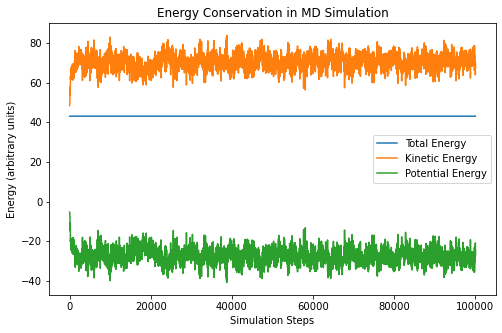

In [20]:
# Run the MD simulation, for clarity parameters from the MC simulation is just copied down here

# Parameters for the simulation
box_size = 5.0  # Box size in nm
N_particles = 49  # Number of particles

C12 = 9.847044e-3  # Lennard-Jones constant for repulsion kg, nm, ns
C6 = 6.2647225  # Lennard-Jones constant for attraction kg, nm, ns
temperature = 293.15  # Temperature in K
step_shift = 0.01  # Random displacement step size in nm
steps = 100000  # Total Monte Carlo steps
record_interval = 20  # Save trajectory every 20 steps
mass = 1.0
time_step = 0.001

# Test parameters
box_size = 5.0  # Box size in nm
N_particles = 49  # Number of particles
c12 = 9.847044e-6  # Lennard-Jones constant (repulsion)
c6 = 6.2647225e-3  # Lennard-Jones constant (attraction)
time_step = 0.001  # Time step in ns
n_steps = 100000  # Number of simulation steps
mass = 1.0  # Mass of particles
temperature = 293.15  # Temperature in K


# Initialize particle positions and velocities
particles = np.zeros((5, N_particles))  # Mass, x, y, vx, vy
grid_size = int(np.sqrt(N_particles))  # Number of particles per row/column
spacing = box_size / grid_size  # Spacing between particles
x_coords = np.linspace(spacing / 2, box_size - spacing / 2, grid_size)
y_coords = np.linspace(spacing / 2, box_size - spacing / 2, grid_size)
x, y = np.meshgrid(x_coords, y_coords)
particles[1] = x.flatten()[:N_particles]  # x-coordinates
particles[2] = y.flatten()[:N_particles]  # y-coordinates
particles[3:5] = np.random.randn(2, N_particles)  # Random initial velocities

# Run the MD simulation
trajectories_md, energies_md = run_md_simulation(particles, box_size, c12, c6, time_step, n_steps, mass)

# Verify results
# Plot total energy over time
plt.figure(figsize=(8, 5))
total_energy = energies_md[:, 0] + energies_md[:, 1]
plt.plot(range(n_steps), total_energy, label="Total Energy")
plt.plot(range(n_steps), energies_md[:, 0], label="Kinetic Energy")
plt.plot(range(n_steps), energies_md[:, 1], label="Potential Energy")
plt.xlabel("Simulation Steps")
plt.ylabel("Energy (arbitrary units)")
plt.title("Energy Conservation in MD Simulation")
plt.legend()
plt.show()



Comparing Potential energy distributions: MC vs MD

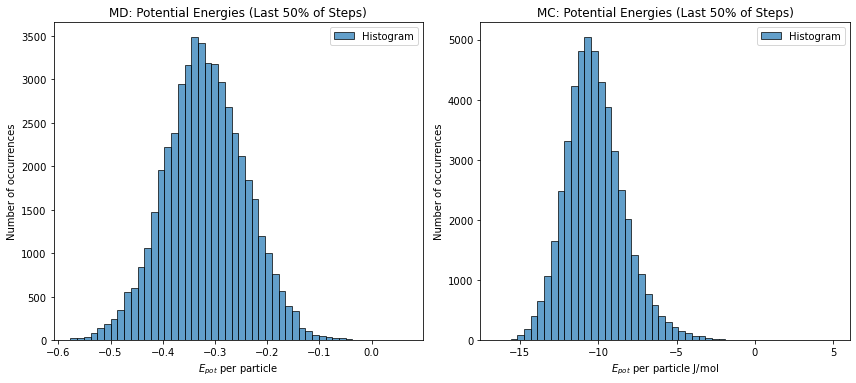

In [10]:
# Extract the last 50% of the steps for potential energy
last_half_start_md = len(energies_md) // 2
last_half_potentials_md = energies_md[last_half_start_md:, 1]  # Extract potential energy

# Normalize potential energy per particle for the last half
last_half_potentials_per_particle_md = last_half_potentials_md / particles.shape[1]  # Divide by number of particles

# Plot histogram of potential energy per particle

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.title("MD: Potential Energies (Last 50% of Steps)")
plt.hist(last_half_potentials_per_particle_md, bins=50, edgecolor='k', alpha=0.7, label="Histogram")
plt.xlabel("$E_{pot}$ per particle ")
plt.ylabel("Number of occurrences")
plt.legend()


plt.subplot(2,2,2)
plt.title("MC: Potential Energies (Last 50% of Steps)")
plt.hist(last_half_energies_per_particle_mc, bins=50, edgecolor='k', alpha=0.7, label="Histogram")
plt.xlabel("$E_{pot}$ per particle J/mol")
plt.ylabel("Number of occurrences")
plt.legend()


plt.tight_layout()
plt.show()

Both distributions look kind of like a Boltzmann distribution. The maximum of the MD simulation is shifted to the right.

Which method is faster?

Having measured the times for the simulations we can clearly state that the MD simulation is significantly faster than the MC simulation.

Look at the trajectory / the position histogram: which method gives a better
sampling of the coordinate space?

Text(0, 0.5, 'Number of occurrences')

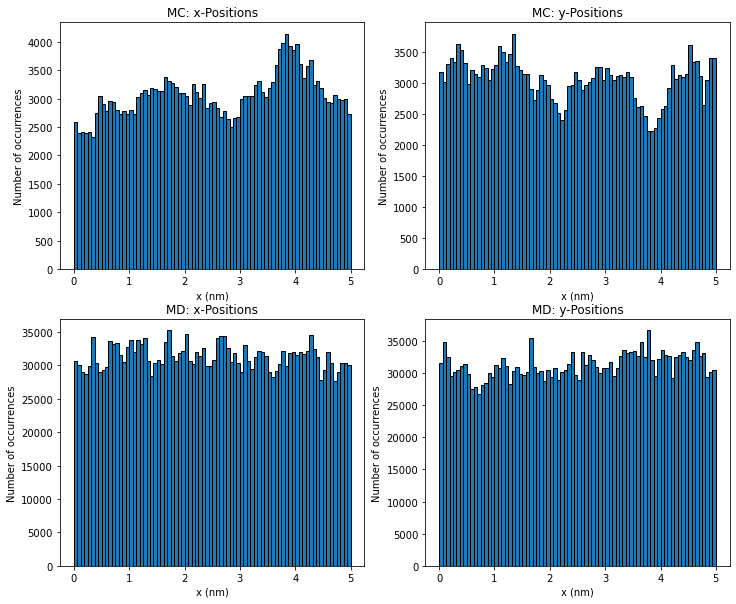

In [11]:
plt.figure(figsize=(12, 10))

# MC: x positions
plt.subplot(2, 2, 1)
plt.title("MC: x-Positions")
plt.hist(traj_mc[:, 0].flatten(), bins=80, edgecolor='k')
plt.xlabel("x (nm)")
plt.ylabel("Number of occurrences")

# MC: x positions
plt.subplot(2, 2, 2)
plt.title("MC: y-Positions")
plt.hist(traj_mc[:, 1].flatten(), bins=80, edgecolor='k')
plt.xlabel("x (nm)")
plt.ylabel("Number of occurrences")

# MD: x positions
plt.subplot(2, 2, 3)
plt.title("MD: x-Positions")
plt.hist(trajectories_md[:, 0].flatten(), bins=80, edgecolor='k')
plt.xlabel("x (nm)")
plt.ylabel("Number of occurrences")

# MD: y positions
plt.subplot(2, 2, 4)
plt.title("MD: y-Positions")
plt.hist(trajectories_md[:, 1].flatten(), bins=80, edgecolor='k')
plt.xlabel("x (nm)")
plt.ylabel("Number of occurrences")



The sampling appears quite similar between both methods, the MD might be slightly better.

Since our calculation of the RDF from last week turned out to be incorrect and we haven’t yet found a proper solution, we decided not to include this part in the analysis for now. Hopefully, we’ll see a working version during the tutorial on Friday, and we can consider implementing it into this task afterward. 😊